# Letterboxd movie recommender

Read ``README.md`` to download the dataset and export your Letterboxd data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from unidecode import unidecode

try:
    from qbstyles import mpl_style

    mpl_style(dark=True)
    # plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
except:
    plt.style.use("dark_background")

from IPython.display import clear_output

clear_output()

from surprise import BaselineOnly, Dataset, Reader
from surprise.prediction_algorithms import BaselineOnly, KNNWithMeans, CoClustering, SVD, SVDpp
from surprise.model_selection import train_test_split

In [2]:
username= "placeholder_username"
ratings = pd.read_csv("letterboxd_data/ratings_export.csv", usecols=["movie_id","rating_val","user_id"], na_filter=False)
your_ratings = pd.read_csv(f"user_data/ratings.csv", usecols=["Name", "Year", "Rating"])
movie_data = pd.read_csv("letterboxd_data/movie_data.csv", lineterminator="\n",usecols = ["genres","image_url","movie_id","movie_title","popularity","production_countries","runtime","spoken_languages","tmdb_id","vote_average","vote_count","year_released"], na_filter=False)

In [3]:
# Replace movie Title + Year by true movie id in your ratings
movie_data = movie_data.loc[~movie_data["year_released"].isin(["", "null"])]
movie_data["year_released"] = movie_data["year_released"].astype(np.int64)
your_ratings_merged = pd.merge(
    your_ratings,
    movie_data[["movie_id", "movie_title", "year_released"]],
    how="left",
    left_on=["Name", "Year"],
    right_on=["movie_title", "year_released"],
)
your_ratings_merged.drop(columns=["Name", "Year", "movie_title", "year_released"], inplace=True)
your_ratings_merged.dropna(axis=0, subset=["movie_id"], inplace=True)
your_ratings_merged = your_ratings_merged.loc[
    ~your_ratings_merged["movie_id"].str.startswith("film:")
]

In [4]:
# scale rating (0.5 to 5) -> (1 to 10)
your_ratings_merged["rating_val"] = 2 * your_ratings_merged["Rating"]
your_ratings_merged.drop("Rating", axis=1, inplace=True)
# add column with your user id
your_ratings_merged["user_id"] = username

## Clean ratings dataframe from obscure movies

In [5]:
nb_ratings_by_movie = np.unique(ratings["movie_id"], return_counts=True)
series_nb_ratings_by_movie = pd.Series(*nb_ratings_by_movie[::-1])

In [6]:
min_nb_ratings_by_movie = 100
# this discards about 94% of movies, which are rated by less than 100 of our 7500 users
# this represents about 2 millions ratings discarded, out of 11 millions

movies_with_enough_ratings = series_nb_ratings_by_movie[
    series_nb_ratings_by_movie > min_nb_ratings_by_movie
].index
ratings = ratings.loc[ratings["movie_id"].isin(movies_with_enough_ratings)]

## Clean ratings dataframe from obscure users and select sample from "super-raters"

Design choice: I could reduce the dataset by either selecting users with many movies rated or taking a random sample of all ratings. I see two downsides here:
1) The first approach lets only users with a lot of ratings which prevents the user ratings to be close from any other user, as there may be a huge discrepancy between the number of movies rated by the user and the dataset users
2) The second approach is tough on users with very few ratings as well

So to avoid this, I divide users in three categories:
- obscure users: those with < 50 ratings. They are discarded
- standard users: those 50 < ratings < 300. They are left unchanged
- super users: those with ratings > 300. I select a random sample from their ratings until the sum of ratings with those of standard users is below a given threshold (say 300000 ratings in total)

In [7]:
nb_ratings, users = np.unique(ratings["user_id"], return_counts=True)
nb_ratings_by_user = pd.Series(users, nb_ratings).sort_values()

In [8]:
min_nb_ratings_by_user = 50
max_nb_ratings_by_user = 200

standard_users = nb_ratings_by_user.loc[
    np.logical_and(
        min_nb_ratings_by_user <= nb_ratings_by_user, nb_ratings_by_user < max_nb_ratings_by_user
    )
].index
super_users = nb_ratings_by_user.loc[nb_ratings_by_user >= max_nb_ratings_by_user].index

ratings_standard_users = ratings.loc[ratings["user_id"].isin(standard_users)]
ratings_super_users = ratings.loc[ratings["user_id"].isin(super_users)]

In [9]:
total_ratings_threshold = 350000

current_nb_ratings = len(ratings_standard_users)
ratings_super_users_subset = ratings_super_users.sample(
    total_ratings_threshold - current_nb_ratings
)

In [10]:
ratings = pd.concat([ratings_standard_users, ratings_super_users_subset], ignore_index=True)

In [11]:
del ratings_super_users
del ratings_super_users_subset
del ratings_standard_users

## Add user's ratings to full ratings dataframe

In [12]:
ratings = pd.concat([ratings, your_ratings_merged], axis=0, ignore_index=True)

## Load dataset

In [13]:
reader = Reader(rating_scale=(1, 10))

In [14]:
data = Dataset.load_from_df(ratings[["user_id", "movie_id", "rating_val"]], reader)

## Train and test algorithms

In [15]:
trainset = data.build_full_trainset()

In [16]:
algo_dict = {
    "baseline": BaselineOnly(),
    "KNN with means (K=10)": KNNWithMeans(k=10, sim_options={"name": "pearson", "min_support": 3}),
    "Co-clustering": CoClustering(),
    "SVD": SVD(),
    "SVD++": SVDpp(),
}

In [17]:
all_movies = ratings["movie_id"].unique()
seen_movies = ratings.loc[ratings["user_id"] == username]["movie_id"].unique()
unseen_movies = list(set(all_movies) - set(seen_movies))
test_df = pd.DataFrame({"movie_id": unseen_movies, "rating": 0.0, "user_id": username})
test_processed = Dataset.load_from_df(
    test_df[["user_id", "movie_id", "rating"]], reader
)  # use load_from_df to convert the test dataframe to the Dataset format required by step 3
_, test = train_test_split(
    test_processed, test_size=1.0, shuffle=False
)  # use train_test_split to convert test_processed to list of tuples required in step 4

In [18]:
predictions_full = pd.DataFrame(index=unseen_movies)

for algo_name, algo in algo_dict.items():
    print(f"\nTraining algo {algo_name}...")
    algo.fit(trainset)
    algo_predictions = algo.test(test)
    algo_movies, prediction_values = zip(*[(i.iid, i.est) for i in algo_predictions])
    predictions_full[f"prediction {algo_name}"] = pd.Series(prediction_values, index=algo_movies)


Training algo baseline...
Estimating biases using als...

Training algo KNN with means (K=10)...
Computing the pearson similarity matrix...
Done computing similarity matrix.

Training algo Co-clustering...

Training algo SVD...

Training algo SVD++...


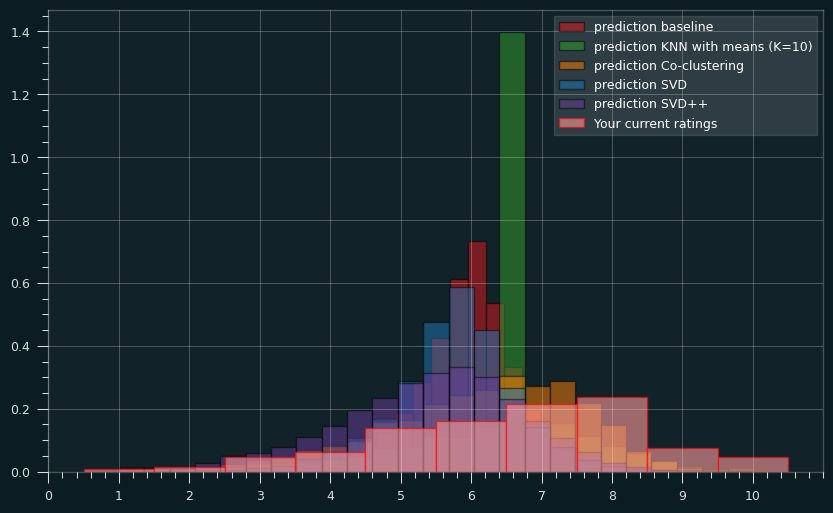

In [19]:
plt.figure(figsize=(10, 6))
for col in predictions_full.columns:
    predictions_full[col].hist(label=col, alpha=0.5, density=True, bins=25, edgecolor="k")


your_ratings_merged["rating_val"].hist(
    density=True, alpha=0.6, label="Your current ratings", bins=np.arange(0.5, 11.5), edgecolor="r"
)

plt.xticks(range(11))
plt.legend()

In [20]:
predictions_with_metadata = pd.merge(
    predictions_full, movie_data, left_index=True, right_on="movie_id"
).reset_index()

In [21]:
n_best_movies = 100

In [22]:
for algo_name in algo_dict:
    best_predictions = predictions_with_metadata.sort_values(
        f"prediction {algo_name}", ascending=False
    )
    best_predictions = best_predictions.iloc[:n_best_movies]
    # Uncomment following line to get only relevant columns
    # best_predictions = best_predictions[["tmdb_id", "movie_title", "year_released"]]

    best_predictions.rename(
        columns={"tmdb_id": "tmdbID", "movie_title": "Title", "year_released": "Year"}, inplace=True
    )


    best_predictions.to_csv(f"recommendations {unidecode(algo_name)}.csv", index=False)